---
### Closed-Form Solution
Solve for lambda and Y using a built-in optimization library in Python.

In [84]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from joblib import Parallel, delayed
import pandas as pd
import time

# Constants
a1 = 23
a2 = 15
a3 = 10.5
a4 = 8.0
a5 = 5.5
a6 = 1.4
k1 = 0.10
k2 = 0.08
k3 = 0.08
k4 = 0.07
k5 = 0.07
k6 = 0.05
N = 200
# b_min, b_max = 0.001, 0.010
b_min, b_max = 1e-3, 40
b_vals = np.logspace(np.log10(b_min), np.log10(b_max), N)
#b_vals = np.linspace(b_min, b_max, N+1)
# try different IC's
# try even or odd

### Softmax transformation

In [ ]:
# Softmax transformation from u1, u2 -> theta1, theta2, theta3 (LogSumExp)
from scipy.special import logsumexp
def softmax_partition(u):
    u1, u2, u3, u4, u5 = u
    u = np.clip(u, -500, 500)
    logZ = logsumexp([u1, u2, u3, u4, u5, 0.0])
    theta1 = np.exp(u1 - logZ)
    theta2 = np.exp(u2 - logZ)
    theta3 = np.exp(u3 - logZ)
    theta4 = np.exp(u4 - logZ)
    theta5 = np.exp(u5 - logZ)
    theta6 = np.exp(-logZ)
    return theta1, theta2, theta3, theta4, theta5, theta6

def objective_softmax(u, b_val, alpha=1e-1):
    try:
        theta1, theta2, theta3, theta4, theta5, theta6 = softmax_partition(u)
        if theta1 < 1e-5:
            return np.inf
        term_Y1 = (a1 * theta2) / (b_val * theta1) + k1 - 1
        Y1 = 0.5 * (np.sqrt(term_Y1**2 + 4 * k1) - term_Y1)
        term_Y2 = (a2 * theta3) / (b_val * theta1) + k2 - (1 - Y1)
        Y2 = 0.5 * (np.sqrt(term_Y2**2 + 4 * (1 - Y1) * k2) - term_Y2)
        term_Y3 = (a3 * theta4) / (b_val * theta1) + k3 - (1 - Y1 - Y2)
        Y3 = 0.5 * (np.sqrt(term_Y3**2 + 4 * (1 - Y1 - Y2) * k3) - term_Y3)
        term_Y4 = (a4 * theta5) / (b_val * theta1) + k4 - (1 - Y1 - Y2 - Y3)
        Y4 = 0.5 * (np.sqrt(term_Y4**2 + 4 * (1 - Y1 - Y2 - Y3) * k4) - term_Y4)
        term_Y5 = (a5 * theta6) / (b_val * theta1) + k5 - (1 - Y1 - Y2 - Y3 - Y4)
        Y5 = 0.5 * (np.sqrt(term_Y5**2 + 4 * (1 - Y1 - Y2 - Y3 - Y4) * k5) - term_Y5)

        if any(np.isnan([Y1, Y2, Y3, Y4, Y5])):
            return np.inf

        Y6 = (a5 * theta6 / b_val) * (Y5 / (k5 + Y5))
        # regularization
        reg = alpha * np.sum(u**2)
        return -b_val * Y6 + reg
    except Exception as e:
        print("Error in objective:", e)
        return np.inf

def optimize_for_b_softmax(b_val, trials=1):
    best_result = None
    for _ in range(trials):
        u0 = np.random.normal(0, 0.5, size=5)
        # Nelder-Mead is dependent on the initial conditions
        result = minimize(lambda u: objective_softmax(u, b_val),
                          u0,
                          method='L-BFGS-B',  # Switch to gradient-based method
                          options={
                              'maxiter': 2000,      # Maximum iterations
                              'ftol': 1e-12,       # Function tolerance (relative change in objective)
                              'gtol': 1e-10,       # Gradient tolerance (norm of gradient)
                              'factr': 1e1,        # Factor for machine precision tolerance (lower = stricter)
                              'maxfun': 15000       # Maximum function evaluations
                          })
        if result.success:
            u_opt = result.x
            theta1, theta2, theta3, theta4, theta5, theta6 = softmax_partition(u_opt)
            if theta1 < 1e-5:
                continue

            term_Y1 = (a1 * theta2) / (b_val * theta1) + k1 - 1
            Y1 = 0.5 * (np.sqrt(term_Y1**2 + 4 * k1) - term_Y1)
            term_Y2 = (a2 * theta3) / (b_val * theta1) + k2 - (1 - Y1)
            Y2 = 0.5 * (np.sqrt(term_Y2**2 + 4 * (1 - Y1) * k2) - term_Y2)
            term_Y3 = (a3 * theta4) / (b_val * theta1) + k3 - (1 - Y1 - Y2)
            Y3 = 0.5 * (np.sqrt(term_Y3**2 + 4 * (1 - Y1 - Y2) * k3) - term_Y3)
            term_Y4 = (a4 * theta5) / (b_val * theta1) + k4 - (1 - Y1 - Y2 - Y3)
            Y4 = 0.5 * (np.sqrt(term_Y4**2 + 4 * (1 - Y1 - Y2 - Y3) * k4) - term_Y4)
            term_Y5 = (a5 * theta6) / (b_val * theta1) + k5 - (1 - Y1 - Y2 - Y3 - Y4)
            Y5 = 0.5 * (np.sqrt(term_Y5**2 + 4 * (1 - Y1 - Y2 - Y3 - Y4) * k5) - term_Y5)
            Y6 = (a5 * theta6 / b_val) * (Y5 / (k5 + Y5))
            Y7 = (theta2 / theta1) * Y6
            Y8 = (theta3 / theta1) * Y6
            Y9 = (theta4 / theta1) * Y6
            Y10 = (theta5 / theta1) * Y6
            Y11 = (theta6 / theta1) * Y6

            lambda_val = b_val * Y6
            r_denom = ((k1 + Y1) / (a1 * Y7)) + ((k2 + Y2) / (a2 * Y8)) + ((k3 + Y3) / (a3 * Y9)) + ((k4 + Y4) / (a4 * Y10)) + ((k5 + Y5) / (a5 * Y11))
            r_avg = 1 / r_denom if r_denom != 0 else np.nan

            best_result = [b_val,
                           [theta1, theta2, theta3, theta4, theta5, theta6],
                           [Y1, Y2, Y3, Y4, Y5, Y6, Y7, Y8, Y9, Y10, Y11],
                           lambda_val,
                           r_avg]
            break
    if best_result is None:
        print(f"Optimization failed for b = {b_val}")
    return best_result

# Parallel execution
start = time.time()
results = Parallel(n_jobs=-1)(delayed(optimize_for_b_softmax)(b) for b in b_vals)
results = [r for r in results if r is not None]
print(f"Optimization completed in {time.time() - start:.2f} seconds.")

# Organize into arrays
b_arr       = np.array([r[0] for r in results])
theta_arr   = np.array([r[1] for r in results])
Y_arr       = np.array([r[2] for r in results])
lambda_arr  = np.array([r[3] for r in results])
r_avg_arr   = np.array([r[4] for r in results])

theta1_arr, theta2_arr, theta3_arr, theta4_arr, theta5_arr, theta6_arr = theta_arr.T
Y1_arr, Y2_arr, Y3_arr, Y4_arr, Y5_arr, Y6_arr, Y7_arr, Y8_arr, Y9_arr, Y10_arr, Y11_arr = Y_arr.T

Optimization completed in 0.57 seconds.


### Line fitting

In [86]:
from scipy.stats import linregress
# Perform linear regression
def linear_fit(x, y):
  slope, intercept, r_value, p_value, std_err = linregress(x, y)
  x_fit = np.linspace(min(x), max(x), 201)
  y_fit = slope * x_fit + intercept
  r_squared = r_value**2
  return [x_fit, y_fit, r_squared, slope, intercept]

# lambda vs. b (linear)
b_lambda_fit = linear_fit(b_arr, lambda_arr)
Y3_lambda_fit = linear_fit(Y3_arr, lambda_arr)
Y4_lambda_fit = linear_fit(Y4_arr, lambda_arr)
Y5_lambda_fit = linear_fit(Y5_arr, lambda_arr)

### Plot the result

C:\Users\huang\AppData\Local\Temp\ipykernel_65128\1951670862.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend() # show the label


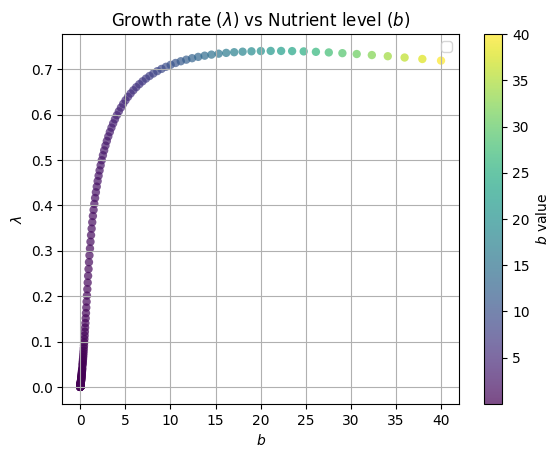

C:\Users\huang\AppData\Local\Temp\ipykernel_65128\1951670862.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


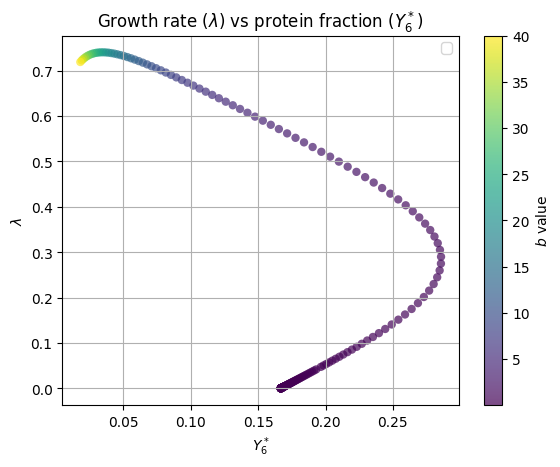

C:\Users\huang\AppData\Local\Temp\ipykernel_65128\1951670862.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


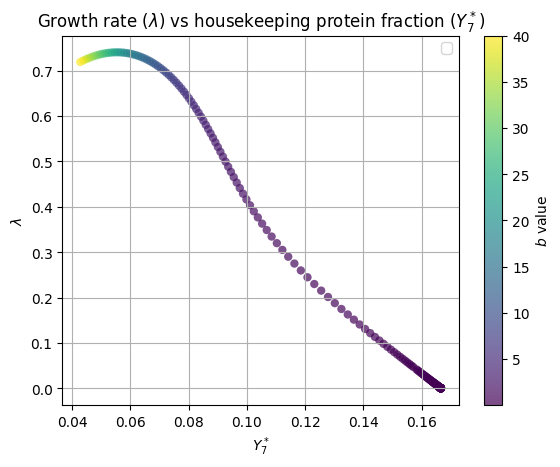

C:\Users\huang\AppData\Local\Temp\ipykernel_65128\1951670862.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


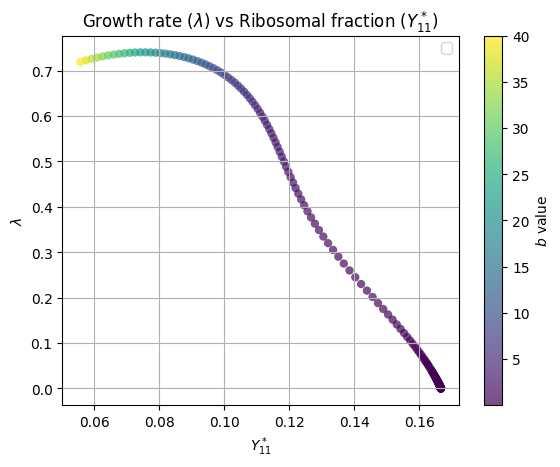

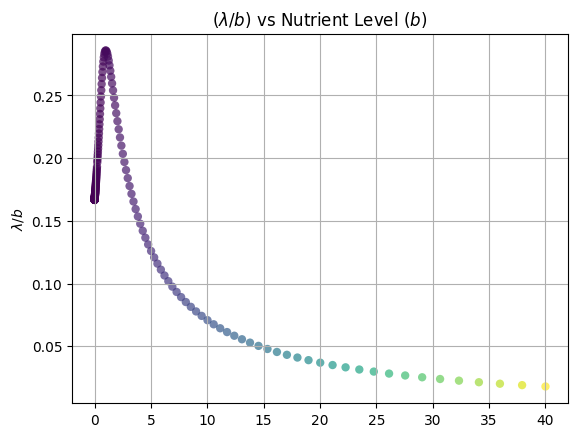

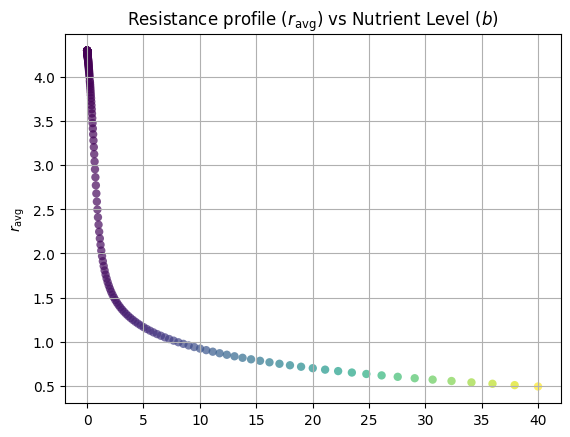

In [87]:
# Growth rate to nutrient level (b)
plt.figure()
# plt.plot(b_lambda_fit[0], b_lambda_fit[1], '-', label=f'Linear fit: y = {b_lambda_fit[3]:.3f}x + {b_lambda_fit[4]:.3f}\n$R^2$ = {b_lambda_fit[2]:.4f}', color='red') # line of best fit
scatter = plt.scatter(b_arr, lambda_arr, c=b_arr, cmap='viridis', edgecolors='none', alpha=0.7)
plt.colorbar(scatter, label=r'$b$ value')
plt.xlabel(r'$b$')
plt.ylabel(r'$\lambda$')
plt.title(r'Growth rate ($\lambda$) vs Nutrient level ($b$)')
plt.legend() # show the label
plt.grid(True)
plt.show()

# Growth rate to protein fraction (Y3)
plt.figure()
scatter = plt.scatter(Y6_arr, lambda_arr, c=b_arr, cmap='viridis', edgecolors='none', alpha=0.7)
plt.colorbar(scatter, label=r'$b$ value')
plt.xlabel(r'$Y_6^*$')
plt.ylabel(r'$\lambda$')
plt.title(r'Growth rate ($\lambda$) vs protein fraction ($Y_6^*$)')
plt.grid(True)
plt.legend()
plt.show()

# Growth rate to protein fraction (Y4) -> this should be constant
plt.figure()
scatter = plt.scatter(Y7_arr, lambda_arr, c=b_arr, cmap='viridis', edgecolors='none', alpha=0.7)
plt.colorbar(scatter, label=r'$b$ value')
plt.xlabel(r'$Y_7^*$')
plt.ylabel(r'$\lambda$')
plt.title(r'Growth rate ($\lambda$) vs housekeeping protein fraction ($Y_7^*$)')
plt.grid(True)
# plt.xlim(0, 0.001)
plt.legend()
plt.show()

# Growth rate to ribosomal fraction (Y5) with color code
plt.figure()
scatter = plt.scatter(Y11_arr, lambda_arr, c=b_arr, cmap='viridis', edgecolors='none', alpha=0.7)
plt.colorbar(scatter, label=r'$b$ value') # indicator of b value
plt.xlabel(r'$Y_{11}^*$')
plt.ylabel(r'$\lambda$')
plt.title(r'Growth rate ($\lambda$) vs Ribosomal fraction ($Y_{11}^*$)')
plt.grid(True)
plt.legend()
plt.show()

# Yield per unit input
plt.figure()
scatter = plt.scatter(b_arr, lambda_arr / b_arr, c=b_arr, cmap='viridis', edgecolors='none', alpha=0.7)
plt.ylabel(r'$\lambda / b$')
plt.title(r'($\lambda / b$) vs Nutrient Level ($b$)')
plt.grid(True)
plt.show()

# Efficiency and Tradeoffs
plt.figure()
scatter = plt.scatter(b_arr, r_avg_arr, c=b_arr, cmap='viridis', edgecolors='none', alpha=0.7)
plt.ylabel(r'$r_\text{avg}$')
plt.title(r'Resistance profile ($r_\text{avg}$) vs Nutrient Level ($b$)')
plt.grid(True)
plt.show()

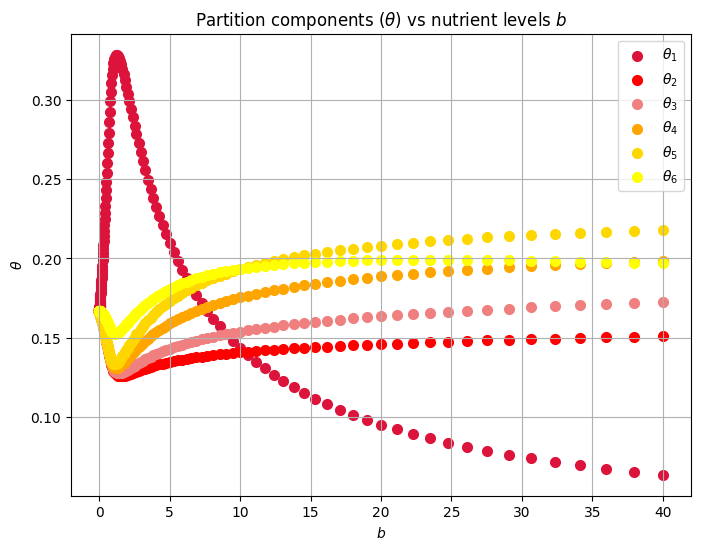

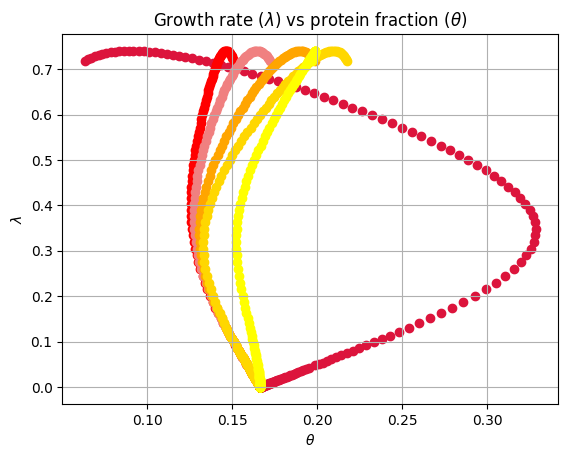

,Nutrient level,Growth rate,theta1,theta2,theta3
0,0.001055,0.000176,0.166779,0.166653,0.166641
1,0.001112,0.000185,0.166662,0.166662,0.166662
2,0.001173,0.000196,0.166666,0.166661,0.166661
3,0.001237,0.000206,0.166806,0.166632,0.166633
4,0.001305,0.000217,0.166662,0.166662,0.166662
...,...,...,...,...,...
187,32.326320,0.730992,0.071565,0.149373,0.169680
188,34.094333,0.728423,0.069407,0.149782,0.170344
189,35.959044,0.725525,0.067331,0.150199,0.171003
190,37.925740,0.722295,0.065334,0.150624,0.171660


'\n# numerical experiment\nprint(theta2_arr / np.sqrt(b_arr)) # beta\nprint(theta3_arr / b_arr) # gamma\nprint(theta2_arr / theta3_arr * np.sqrt(b_arr))\n'

In [88]:
# Partition components to nutrient levels b
# 'red', 'orange', 'olive','maroon', 'lime', 'silver', 'gold'
# 'crimson', 'coral', 'salmon', 'tomato', 'darkred', 'lightcoral'
plt.figure(figsize=(8,6))
# plt.plot(b_arr, theta1_arr, lw=2, label=r'$\theta_1$', color='crimson')
# plt.plot(b_arr, theta2_arr, lw=2, label=r'$\theta_2$', color='red')
# plt.plot(b_arr, theta3_arr, lw=2, label=r'$\theta_3$', color='lightcoral')
# plt.plot(b_arr, theta4_arr, lw=2, label=r'$\theta_4$', color='orange')
# plt.plot(b_arr, theta5_arr, lw=2, label=r'$\theta_5$', color='gold')
# plt.plot(b_arr, theta6_arr, lw=2, label=r'$\theta_6$', color='yellow')
plt.scatter(b_arr, theta1_arr, lw=2, label=r'$\theta_1$', color='crimson')
plt.scatter(b_arr, theta2_arr, lw=2, label=r'$\theta_2$', color='red')
plt.scatter(b_arr, theta3_arr, lw=2, label=r'$\theta_3$', color='lightcoral')
plt.scatter(b_arr, theta4_arr, lw=2, label=r'$\theta_4$', color='orange')
plt.scatter(b_arr, theta5_arr, lw=2, label=r'$\theta_5$', color='gold')
plt.scatter(b_arr, theta6_arr, lw=2, label=r'$\theta_6$', color='yellow')
plt.xlabel(r'$b$')
plt.ylabel(r'$\theta$')
plt.title(r'Partition components ($\theta$) vs nutrient levels $b$')
plt.grid(True)
plt.legend()
plt.show()

# Growth rate to protein partition \theta
plt.figure()
plt.scatter(theta1_arr, lambda_arr, label=r'$\theta_1$', c='crimson')
plt.scatter(theta2_arr, lambda_arr, label=r'$\theta_2$', c='red')
plt.scatter(theta3_arr, lambda_arr, label=r'$\theta_3$', c='lightcoral')
plt.scatter(theta4_arr, lambda_arr, label=r'$\theta_4$', c='orange')
plt.scatter(theta5_arr, lambda_arr, label=r'$\theta_5$', c='gold')
plt.scatter(theta6_arr, lambda_arr, label=r'$\theta_6$', c='yellow')
# plt.plot(theta1_arr, lambda_arr, lw=2, label=r'$\theta_1$', color='crimson')
# plt.plot(theta2_arr, lambda_arr, lw=2, label=r'$\theta_2$', color='red')
# plt.plot(theta3_arr, lambda_arr, lw=2, label=r'$\theta_3$', color='lightcoral')
# plt.plot(theta4_arr, lambda_arr, lw=2, label=r'$\theta_4$', color='orange')
# plt.plot(theta5_arr, lambda_arr, lw=2, label=r'$\theta_5$', color='gold')
# plt.plot(theta6_arr, lambda_arr, lw=2, label=r'$\theta_6$', color='yellow')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\lambda$')
plt.title(r'Growth rate ($\lambda$) vs protein fraction ($\theta$)')
plt.grid(True)
plt.show()

# Put in DataFrame
df = pd.DataFrame({
    "Nutrient level": b_arr,
    "Growth rate": lambda_arr,
    "theta1": theta1_arr,
    "theta2": theta2_arr,
    "theta3": theta3_arr,
})
display(df)

'''
# numerical experiment
print(theta2_arr / np.sqrt(b_arr)) # beta
print(theta3_arr / b_arr) # gamma
print(theta2_arr / theta3_arr * np.sqrt(b_arr))
'''

### Small and Large Molecules
The small molecules include metabolites and precursors. Large molecules include different types of proteins.

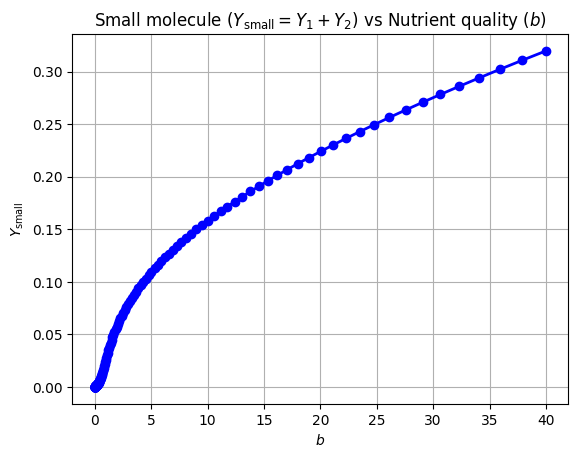

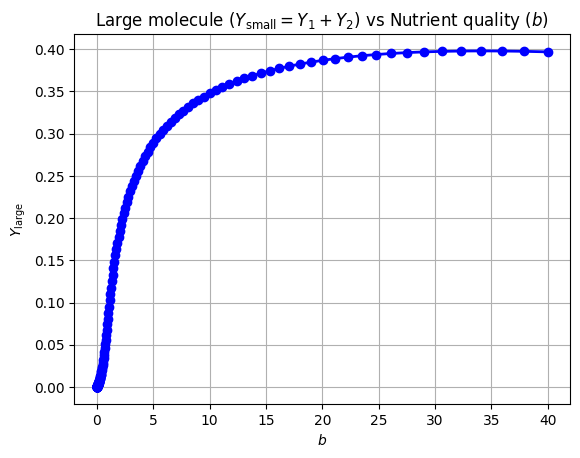

,Nutrient level,Growth rate,Small molecule fraction,Large molecule fraction
0,0.001055,0.000176,0.000010,0.000031
1,0.001112,0.000185,0.000011,0.000032
2,0.001173,0.000196,0.000011,0.000034
3,0.001237,0.000206,0.000012,0.000036
4,0.001305,0.000217,0.000013,0.000038
...,...,...,...,...
187,32.326320,0.730992,0.286101,0.397921
188,34.094333,0.728423,0.294118,0.398060
189,35.959044,0.725525,0.302392,0.397946
190,37.925740,0.722295,0.310929,0.397571


In [89]:
# Discuss different molecdule sizes
small_mol_arr = Y1_arr + Y2_arr
large_mol_arr = Y3_arr + Y4_arr + Y5_arr

# Small molecule (metabolites and a.a.'s) fraction (Y1 + Y2) to b
plt.figure()
plt.plot(b_arr, small_mol_arr, lw=2, label=r'', marker='o', color='blue')
plt.xlabel(r'$b$')
plt.ylabel(r'$Y_\text{small}$')
plt.title(r'Small molecule ($Y_\text{small} = Y_1 + Y_2$) vs Nutrient quality ($b$)')
plt.grid(True)
plt.show()

# Large molecule (proteins) fraction (Y3 + Y4 + Y5) to b
plt.figure()
plt.plot(b_arr, large_mol_arr, lw=2, label=r'', marker='o', color='blue')
plt.xlabel(r'$b$')
plt.ylabel(r'$Y_\text{large}$')
plt.title(r'Large molecule ($Y_\text{small} = Y_1 + Y_2$) vs Nutrient quality ($b$)')
plt.grid(True)
plt.show()

# Put in DataFrame
df = pd.DataFrame({
    "Nutrient level": b_arr,
    "Growth rate": lambda_arr,
    "Small molecule fraction": small_mol_arr,
    "Large molecule fraction": large_mol_arr,
})
display(df)